<a href="https://colab.research.google.com/github/jamarju/demo_orla/blob/master/04_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrucciones

Requisitos: debemos tener en nuestro Google Drive la carpeta `demo_orla` y, dentro, el archivo `alumnos.zip` y el fichero `tiltnet18.pkl` generado por el cuaderno anterior.

1. Menú Entorno de ejecucion -> Cambiar tipo de entorno de ejecución -> Acelerador por hardware: GPU

2. Entorno de ejecución -> Ejecutar todas

3. En la celda nº 6 nos pedirá abrir un enlace e introducir el código de autorización para que el cuaderno pueda acceder a nuestro Google Drive.

# Preparativos
- Instalamos la librería `fastai` y la utilidad `gdown` para descargar archivos de Google Drive
- Descargamos la librería de detección facial S3FD: https://github.com/jamarju/face-detection-pytorch y la red pre-entrenada
- Descargamos la librería de eliminación de fondo MODNet: https://github.com/ZHKKKe/MODNet y la red pre-entrenada

In [1]:
!pip install -U fastai gdown

     |████████████████████████████████| 194kB 9.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 12.8MB 225kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp37-none-any.whl size=9693 sha256=942f5384a4408dcbd1cf1b4aa826b7774d7337d9f363de7e02dcb6fff70bfb34
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchv

In [3]:
!git clone https://github.com/jamarju/face-detection-pytorch
!mv face-detection-pytorch/detectors .
!mv face-detection-pytorch/utils .
!mkdir detectors/s3fd/weights
!gdown --id 1ktVh55p-Ynu6LonSyZtaUJxU23BS0Pdk -O detectors/s3fd/weights/sfd_face.pth

fatal: destination path 'face-detection-pytorch' already exists and is not an empty directory.
mv: cannot stat 'face-detection-pytorch/detectors': No such file or directory
mv: cannot stat 'face-detection-pytorch/utils': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1ktVh55p-Ynu6LonSyZtaUJxU23BS0Pdk
To: /content/detectors/s3fd/weights/sfd_face.pth
89.8MB [00:00, 143MB/s]


In [4]:
!git clone https://github.com/ZHKKKe/MODNet
!gdown https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz -O MODNet/pretrained/modnet_photographic_portrait_matting.ckpt

Cloning into 'MODNet'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 206 (delta 26), reused 54 (delta 17), pack-reused 131
Receiving objects: 100% (206/206), 37.62 MiB | 24.39 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
26.3MB [00:00, 58.9MB/s]


In [5]:
from pathlib import Path
from zipfile import ZipFile
import shutil
import sys

from fastai.basics import *
from fastai.vision.all import *
from fastai.distributed import *
from tqdm.notebook import tqdm

from detectors import S3FD
from utils.bbox import draw_bboxes, crop_thumbnail


In [6]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [10]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_d = Path('/content/drive/MyDrive/demo_orla')
else:
    data_d = Path('data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
temp_d = Path('temp')
temp_d.mkdir(exist_ok=True)

In [12]:
%%time
if not (temp_d / 'alumnos').exists():
    with ZipFile(data_d / 'alumnos.zip', 'r') as z:
        z.extractall('temp')

CPU times: user 17.5 ms, sys: 9.19 ms, total: 26.6 ms
Wall time: 1.07 s


In [13]:
alus_d = temp_d / 'alumnos'

# Paso 1: cargamos las imágenes de nuestros alumnos
- Fuente: https://thispersondoesnotexist.com es una web que genera caras de personas que no existen en la realidad mediante una red neuronal generativa adversaria (GAN).

In [39]:
imgs = [ np.array(Image.open(p)) for p in sorted(alus_d.ls()) ]
names = [ p.stem for p in sorted(alus_d.ls()) ]

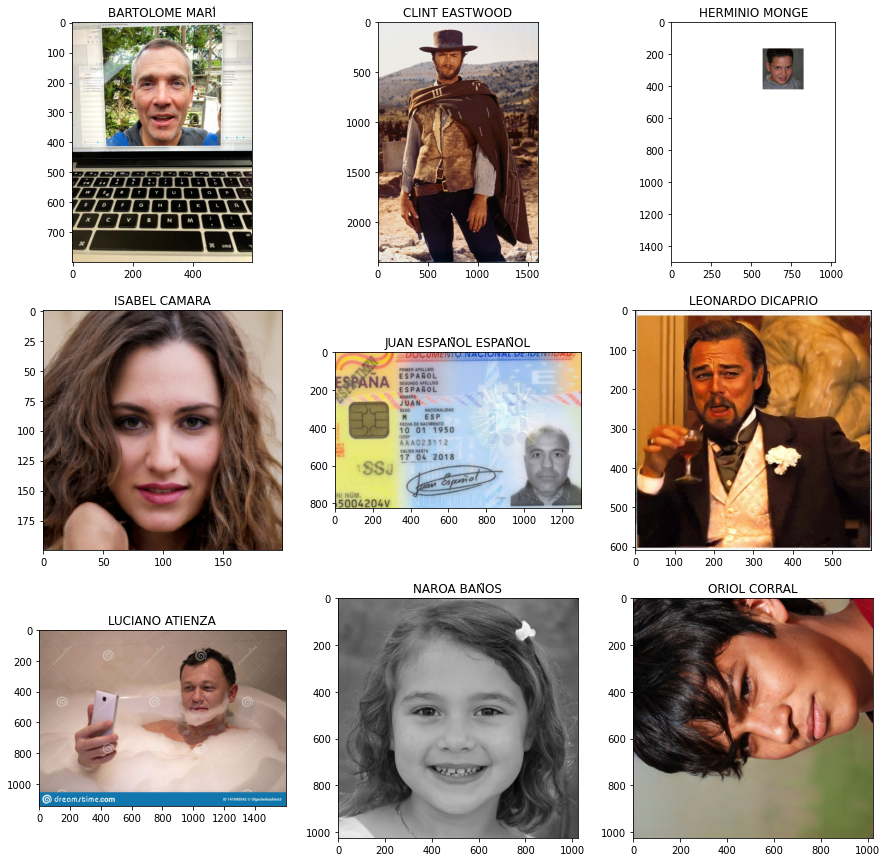

In [40]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(imgs, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 2: quitar fondo

<img src="https://raw.githubusercontent.com/ZHKKKe/MODNet/develop/doc/gif/image_matting_demo.gif">

Vamos a usar la librería [MODNet](https://github.com/ZHKKKe/MODNet) que sirve para eliminar el fondo sin necesidad de un chroma: para una imagen dada, nos devuelve una máscara del mismo tamaño donde cada píxel de la máscara indica si el píxel de la foto original pertenece al sujeto o al fondo.

In [41]:
if (temp_d / 'masks').exists():
    shutil.rmtree(temp_d / 'masks')
(temp_d / 'masks').mkdir()

In [42]:
# clone the repository
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt


/content/MODNet


In [43]:
!python -m demo.image_matting.colab.inference \
        --input-path ../temp/alumnos \
        --output-path ../temp/masks \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt

Process image: BARTOLOME MARÍ.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Process image: CLINT EASTWOOD.jpg
Process image: JUAN ESPAÑOL ESPAÑOL.jpg
Process image: HERMINIO MONGE.jpg
Process image: NAROA BAÑOS.jpg
Process image: LUCIANO ATIENZA.jpg
Process image: ISABEL CAMARA.jpg
Process image: ORIOL CORRAL.jpg
Process image: LEONARDO DICAPRIO.jpg


In [44]:
%cd ..

/content


In [21]:
(temp_d / 'masks').ls()

(#9) [Path('temp/masks/NAROA BAÑOS.png'),Path('temp/masks/ORIOL CORRAL.png'),Path('temp/masks/CLINT EASTWOOD.png'),Path('temp/masks/LEONARDO DICAPRIO.png'),Path('temp/masks/BARTOLOME MARÍ.png'),Path('temp/masks/JUAN ESPAÑOL ESPAÑOL.png'),Path('temp/masks/LUCIANO ATIENZA.png'),Path('temp/masks/HERMINIO MONGE.png'),Path('temp/masks/ISABEL CAMARA.png')]

In [45]:
masks = [ np.array(Image.open(p)) for p in sorted((temp_d / 'masks').ls()) ]

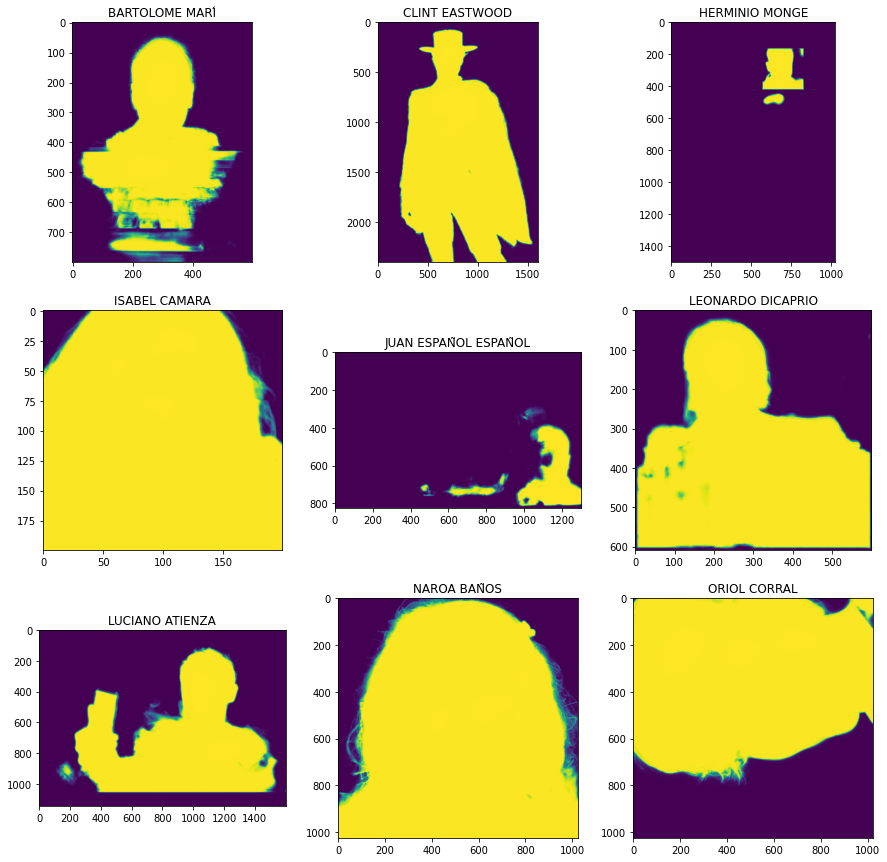

In [46]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(masks, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

In [47]:
imgs_nobg = []

for img, mask in zip(imgs, masks):
    white = np.full_like(img, 255)
    mask = mask[:,:,None].astype(np.float32) / 255
    img_nobg = ((img * mask) + white * (1-mask)).astype(np.uint8)
    #img_nobg.putalpha(Image.fromarray(mask))
    imgs_nobg.append(img_nobg)

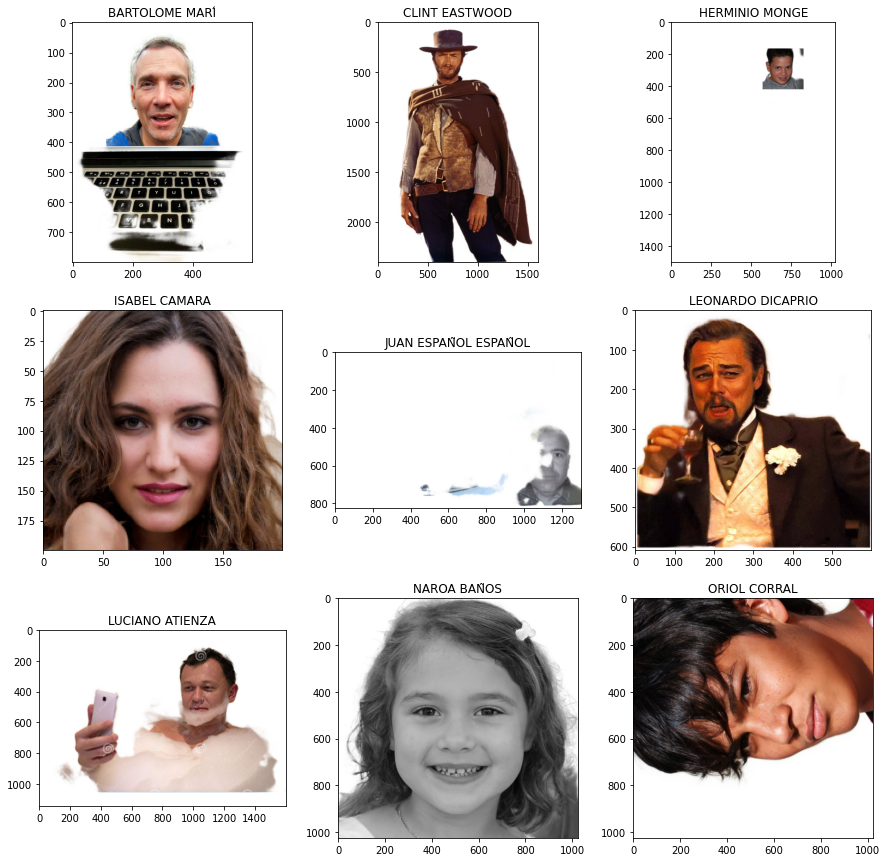

In [48]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(imgs_nobg, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 3: detección de caras

<img src="https://github.com/jamarju/demo_orla/raw/master/img/selfie_demo.png">

Para detectar las caras de una imagen vamos a usar el detector S3FD, uno de los mejores actualmente.

In [49]:
det = S3FD(device='cuda')

[S3FD] loading with cuda
[S3FD] finished loading (2.0125 sec)


In [50]:
bboxes_l = []
boxed_imgs = []
crops = []
crops_nopad = []

for img, img_nobg in tqdm(zip(imgs, imgs_nobg)):
    bboxes = det.detect_faces(img, conf_th=0.9)

    # Versión completa con cajas:
    boxed_img = draw_bboxes(img, bboxes)
    # Recorte para orla (con márgenes)
    crop, _ = crop_thumbnail(img_nobg, bboxes[0], padding=0.7, size=1024)
    # Recorte para detector de orientación (sin márgenes)
    crop_nopad, _ = crop_thumbnail(img, bboxes[0], padding=0.5, size=128)
    
    bboxes_l.append(bboxes)
    boxed_imgs.append(boxed_img)
    crops.append(crop)
    crops_nopad.append(crop_nopad)


## Resultados de la detección

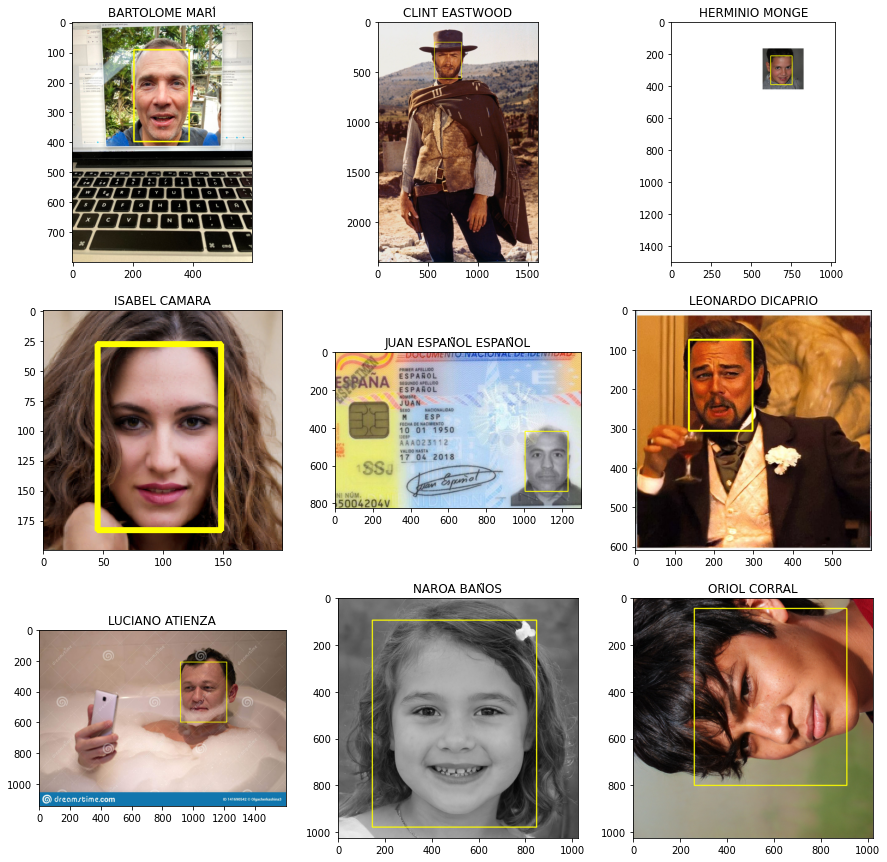

In [51]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(boxed_imgs, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

## Recorte para la orla

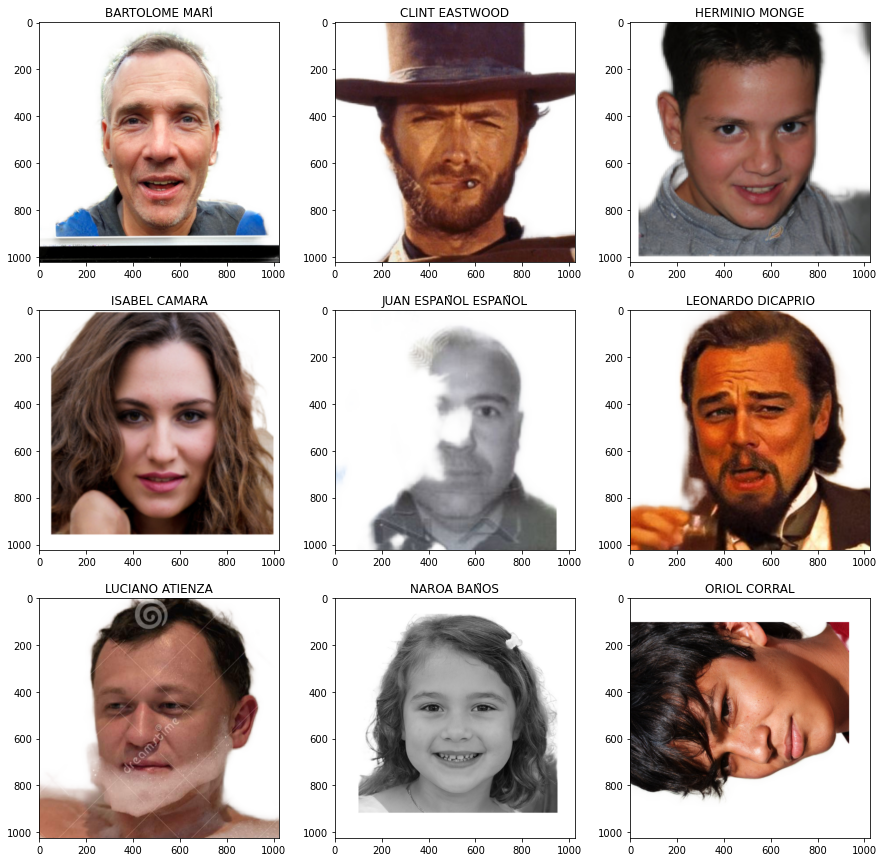

In [52]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(crops, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

## Recorte para el detector de orientación

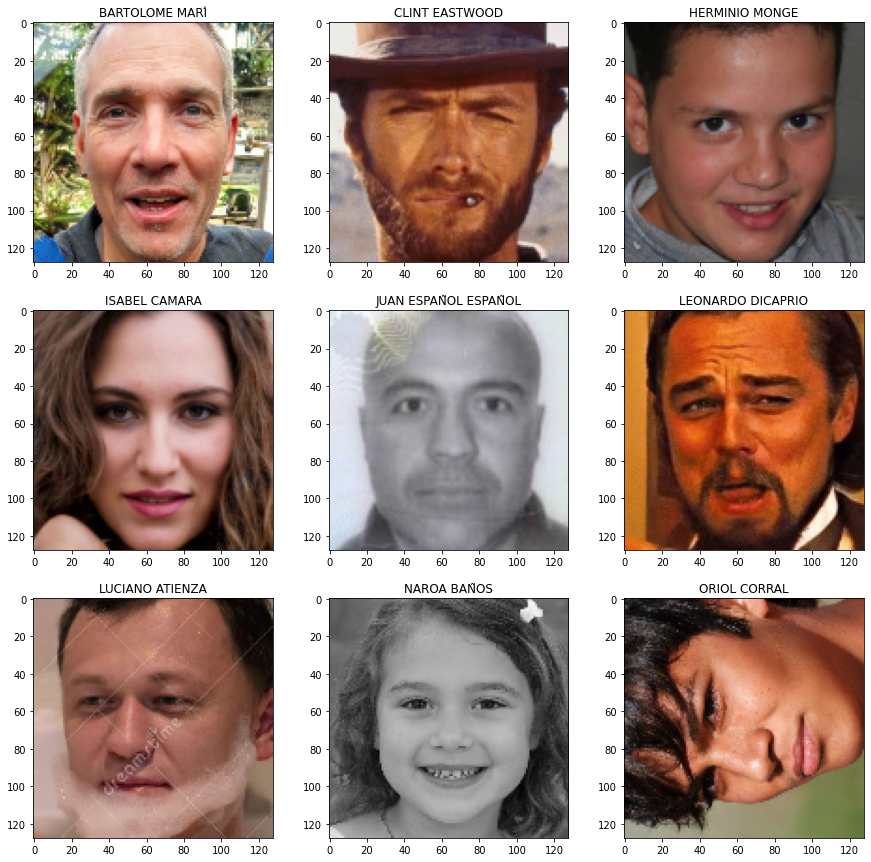

In [56]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(crops_nopad, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# Paso 3: rectificar orientación
En este paso usaremos... ¡la red neuronal que hemos entrenado nosotros mismos en el anterior cuaderno!

In [57]:
tiltnet = load_learner(data_d / 'tiltnet18.pkl', cpu=False)

In [58]:
tiltnet.predict(crops_nopad[2])

('0', tensor(0), tensor([1.0000e+00, 2.9113e-06, 7.8162e-08, 2.1073e-07]))

In [60]:
tiltnet.predict(crops_nopad[8])

('270', tensor(2), tensor([1.8483e-11, 1.0301e-10, 1.0000e+00, 3.2562e-09]))

In [61]:
str_crops = []

for crop, crop_nopad in tqdm(zip(crops, crops_nopad)):
    ori, _, _ = tiltnet.predict(crop_nopad)
    str_crop = np.array(Image.fromarray(crop).rotate(int(ori)))
    str_crops.append(str_crop)

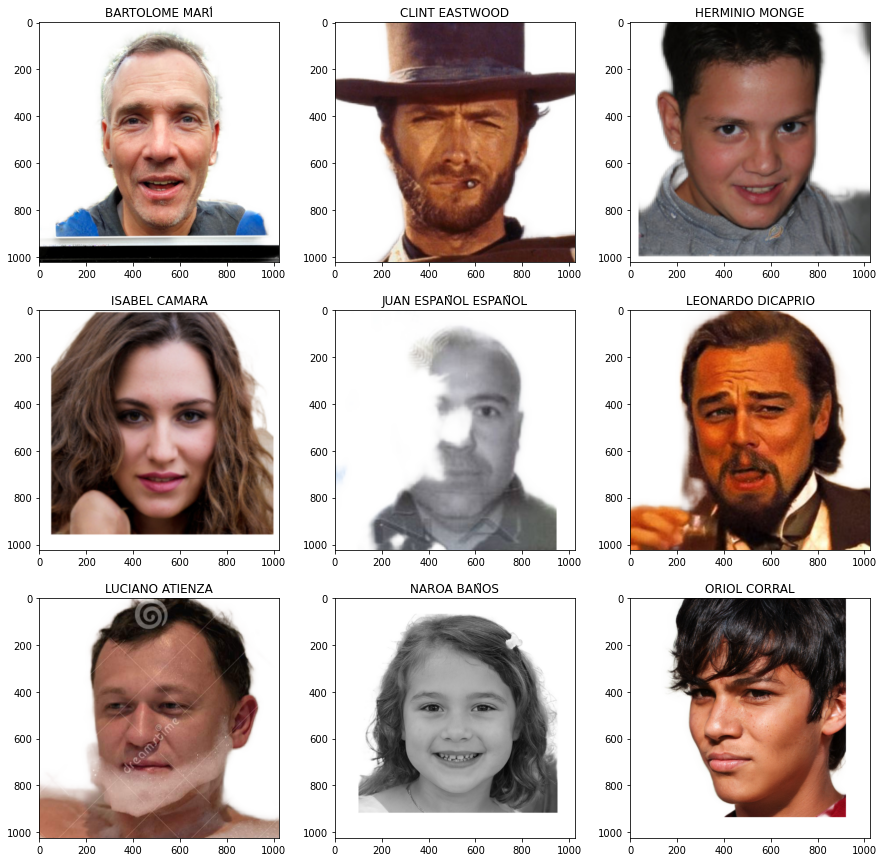

In [62]:
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for img, ax, name in zip(str_crops, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# ¡FIN!

Solo quedaría guardar las imágenes recortadas. Como la eliminación de fondo no ha funcionado muy bien con Juan Español, podríamos guardar una versión final con fondo y otra sin fondo (¡se deja como ejercicio!)

In [63]:
(temp_d / 'out').mkdir(exist_ok=True)

for img, name in zip(str_crops, names):
    Image.fromarray(img).save(temp_d / 'out' / f'{name}.jpg')